In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
import tqdm
import importlib

base_dir = os.path.dirname(os.getcwd())
sys.path.append(base_dir)

from src.kernels import CMEAggregateKernel
from src.means import CMEAggregateMean
from src.models import ExactCMEProcess

### Simulation data

$$
f(x) = \cos(x)\,,\enspace x\in[0, 4\pi]
$$

$$
g(y) = \int f(x) dU_{[y - r, y + r]}(x) = \frac{1}{2r}\left(\sin(y + r) - \sin(y - r)\right)\,,\enspace y\in[0, 4\pi], r > 0
$$

$$
\bar z \sim \mathcal{N}(g(y), \sigma^2)
$$

We use $N=100$ values of individuals $x$ and $n=11$ values of bags $y$ such that individuals in $[y-r, y + r]$ correspond to bag valued $y$

In [3]:
def generate_toy_data(radius, n_bags, noise_std):
    # Define base individuals and bags values
    x = torch.linspace(0, 4 * np.pi, 100)
    y = torch.linspace(0, 4 * np.pi, n_bags)

    # Adapt range of individuals to aggregation areas for each bag
    bags_masks = [(x >= a - radius) & (x <= a + radius) for a in y]
    individuals = torch.cat([x[mask] for mask in bags_masks])
    bags_sizes = [torch.sum(mask).item() for mask in bags_masks]

    # Compute groundtruth latent individuals GP values
    latent_individuals = torch.cos(x)
    
    # Compute aggregate bag values and add observation noise
    latent_aggregate_targets = (torch.sin(y + radius) - torch.sin(y - radius)) / (2 * radius)
    aggregate_targets = latent_aggregate_targets + noise_std * torch.randn_like(latent_aggregate_targets)
    return x, y, bags_sizes, individuals, latent_individuals, latent_aggregate_targets, aggregate_targets 

radius = np.pi / 2
n_bags = 11
noise_std = 0.025

buffer = generate_toy_data(radius=radius, n_bags=n_bags, noise_std=noise_std)
x, y, bags_sizes, individuals, latent_individuals, latent_aggregate_targets, aggregate_targets = buffer

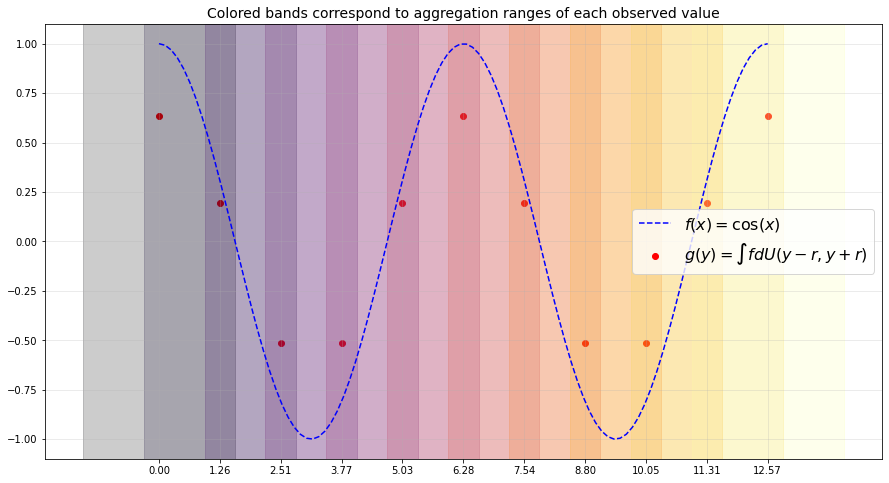

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax.plot(x, latent_individuals, '--', color='blue', label=r'$f(x) = \cos(x)$')

colors = plt.cm.inferno(np.linspace(0, 1, len(y)))
for a, c in zip(y, colors):
    ax.axvspan(a - radius, a + radius, alpha=0.2, color=c)

ax.scatter(y, latent_aggregate_targets, c='red', label=r'$g(y) = \int fdU(y - r, y + r)$')
ax.set_xticks(y)

ax.grid(alpha=0.3)
ax.set_title("Colored bands correspond to aggregation ranges of each observed value", fontsize=14)
plt.legend(fontsize=16)
plt.show()

### Define CME Process Model

In [11]:
individuals_mean = gpytorch.means.ZeroMean()
individuals_kernel = gpytorch.kernels.RBFKernel()
bag_kernel = gpytorch.kernels.RBFKernel()

model = ExactCMEProcess(individuals_mean=individuals_mean, 
                        individuals_kernel=individuals_kernel,
                        bag_kernel=bag_kernel,
                        train_individuals=individuals,
                        train_bags=y,
                        train_aggregate_targets=aggregate_targets,
                        bags_sizes=bags_sizes,
                        lbda=1e-3,
                        likelihood=gpytorch.likelihoods.GaussianLikelihood())

### MLE estimate of hyperparameters

In [12]:
model.train()
model.likelihood.train()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

epochs = 150

epoch_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
for i in epoch_iter:
    optimizer.zero_grad()
    output = model(y)
    loss = -mll(output, aggregate_targets)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.update_cme_estimate_parameters()
    epoch_iter.set_postfix(loss=loss.item())

print("Final Marginal Likelihood : ", torch.exp(-loss).item())


Final Marginal Likelihood :  0.879457950592041


### Make predictions

In [13]:
model.eval()
model.likelihood.eval()

with torch.no_grad():
    y_test = torch.linspace(0, 4 * np.pi, 200)
    observed_pred = model.likelihood(model(y_test))
    individuals_posterior = model.predict(x)

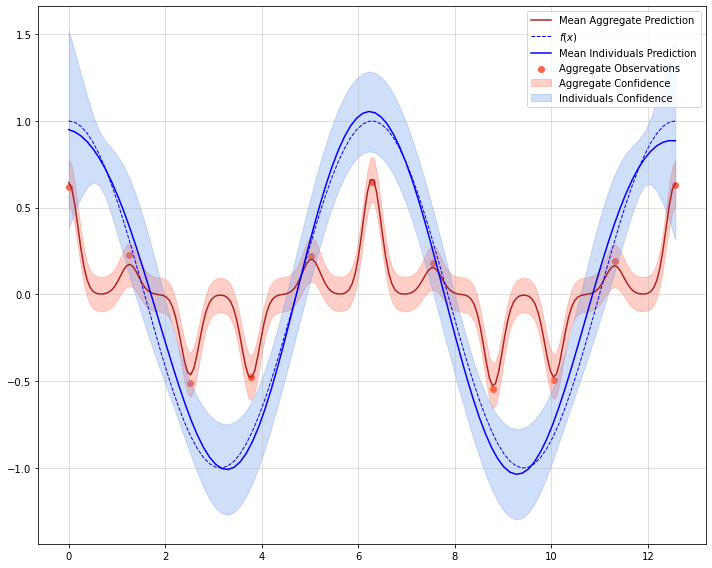

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
lower, upper = observed_pred.confidence_region()
ax.scatter(y, aggregate_targets, color='tomato', label='Aggregate Observations')
ax.plot(y_test, observed_pred.mean, 'firebrick', label='Mean Aggregate Prediction')
ax.fill_between(x=y_test, y1=lower.numpy(), y2=upper.numpy(), color='tomato', alpha=0.3, label='Aggregate Confidence')

lower, upper = individuals_posterior.confidence_region()
lower, upper = lower.detach(), upper.detach()
ax.plot(x, latent_individuals, '--', linewidth=1, color='blue', label=r'$f(x)$')
ax.plot(x, individuals_posterior.mean.detach(), 'blue', label='Mean Individuals Prediction')
ax.fill_between(x=x, y1=lower.numpy(), y2=upper.numpy(), color='cornflowerblue', alpha=0.3, label='Individuals Confidence')

ax.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

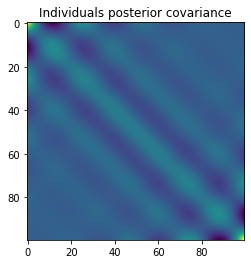

In [15]:
plt.imshow(individuals_posterior.covariance_matrix.detach())
plt.title("Individuals posterior covariance")
plt.show()